In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+8459b0669c 	w_2021_20 w_latest current setup


## making a master bias

```
pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'bias' AND exposure.science_program IN ( '6806D' )" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all \
    -o u/youtsumi/calib/bias/run_6806D \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/cpBias.yaml \
    --register-dataset-types \
    -j 8
```

## certify a master bias
```
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft u/youtsumi/calib/bias/run_6806D /calib/run_6806D bias
```

## make LSST related info available in the repository
```
butler write-curated-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft LSSTCam 
```

## make a master dark 
```
pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'dark' AND exposure.science_program IN ( '6806D' )" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_6806D \
    -o u/youtsumi/calib/dark/run_6806D \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/cpDark.yaml \
    --register-dataset-types \
    -j 8
```

got this error
```
RuntimeError: maskedImage bbox (minimum=(0, 0), maximum=(4607, 4095)) != biasMaskedImage bbox (minimum=(0, 0), maximum=(4095, 4003))
```
had to change doTrim=True

## certify a master dark
```
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft u/youtsumi/calib/dark/run_6806D /calib/run_6806D dark
```

## make defects info
```
pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'bias' AND exposure.science_program IN ( '6806D' )" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_6806D \
    -o u/youtsumi/calib/defects/run_6806D \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/findDefects.yaml \
    --register-dataset-types \
    -j 8    
```

## ceretify it
```
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft u/youtsumi/calib/defects/run_6806D /calib/run_6806D defects
```

## run spot task
```
PYTHONPATH=mixcoatl/python:$PYTHONPATH pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_6806D \
    -d "instrument='LSSTCam' AND exposure.observation_type='spot' AND exposure.science_program IN ( '6864D' )" \
    -o u/youtsumi/spot/1st \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types -j 8
```

In [2]:
# Import necessary libraries
from lsst.daf.butler import Butler
%matplotlib inline

import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import numpy


def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')


# point to the Repo we are working on, these lines will print out what's in the Repo.
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml"
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/raw/all
u/youtsumi/calib/bias/run_6806D
u/youtsumi/calib/bias/run_6806D/20210522T012232Z
/calib/run_6806D
LSSTCam/calib
LSSTCam/calib/unbounded
u/youtsumi/calib/dark/run_6806D
u/youtsumi/calib/dark/run_6806D/20210522T174047Z
u/youtsumi/calib/dark/run_6806D/20210522T175400Z
u/youtsumi/calib/defects/run_6806D
u/youtsumi/calib/defects/run_6806D/20210522T201601Z
u/youtsumi/calib/defects/run_6806D/20210522T203525Z
u/youtsumi/calib/defects/run_6806D/20210522T204002Z
u/youtsumi/spot/1st
u/youtsumi/spot/1st/20210523T023357Z


In [3]:
# Specify collection. I know 'u/youtsumi/spot/20210504b' is the one. So pick it
collections = 'u/youtsumi/spot/1st'
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

134557 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
4800 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrument, detector}, ExposureF, isCali

In [4]:
datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections))
results = []

for aref in datasetRefs[:3]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        if img.min()<22000:
            raise
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/LSSTCam/raw/all/raw/20191030/MC_C_20191030_001326/raw_LSSTCam_unknown_MC_C_20191030_001326_R22_S11_LSSTCam_raw_all.fits(MC_C_20191030_001326): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/LSSTCam/raw/all/raw/20191030/MC_C_20191030_000497/raw_LSSTCam_unknown_MC_C_20191030_000497_R22_S11_LSSTCam_raw_all.fits(MC_C_20191030_000497): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/LSSTCam/raw/all/raw/20191030/MC_C_20191030_001890/raw_LSSTCam_unknown_MC_C_20191030_001890_R22_S11_LSSTCam_raw_all.fits(MC_C_20191030_001890): Unable to determine the filter


<Figure size 720x720 with 0 Axes>

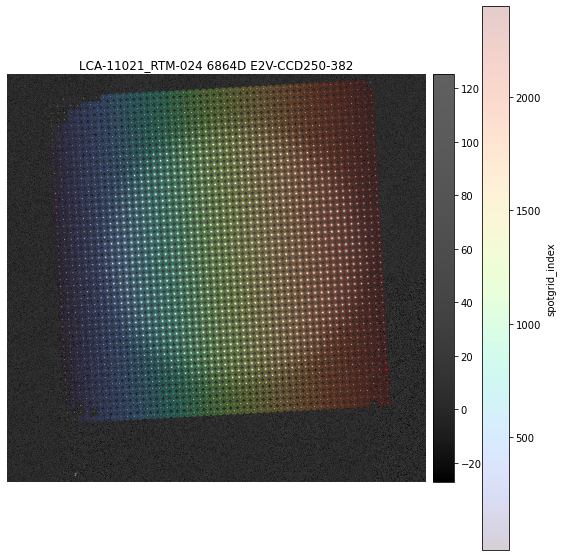

In [5]:
fig = plt.figure(figsize=(10,10))

calexp = subbutler.get("postISRCCD",dataId=aref.dataId)
src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
display(calexp,
        " ".join([ calexp.getMetadata()[a] for a in [ "RAFTNAME", "RUNNUM", "LSST_NUM" ] ])
)
plt.scatter( src["spotgrid_x"],src["spotgrid_y"],
             c = src["spotgrid_index"],cmap='turbo',alpha=0.2)
plt.colorbar(label="spotgrid_index")
